<a href="https://colab.research.google.com/github/skulshreshtha/student-test-scores-prediction/blob/main/Student_Test_Score_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective
I will be trying to predict the post-test scores for students using features about the school setting, students, and their pre-test scores.
## Data Used
The dataset used here is taken from Kaggle with the title "*Predict Test Scores of students*"

Data Source: [Click Here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students/download)

Data Dictionary: Available in Data Explorer Section on [this page](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students)

## Evaluation
To evaluate different models, I will be using MAE and R<sup>2</sup> as the evaluation metric

## Step 1: Importing required libraries & modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [3]:
!pip install -qq pycaret[full]

In [4]:
from pycaret.utils import enable_colab
from pycaret.regression import *
enable_colab()

Colab mode enabled.


## Step 2: Ingesting data

In [5]:
df_orig = pd.read_csv('test_scores.csv')

## Step 3: EDA & Feature Engineering

In [6]:
df_orig.head()

school school_setting school_type classroom teaching_method  n_student  \
0  ANKYI          Urban  Non-public       6OL        Standard       20.0   
1  ANKYI          Urban  Non-public       6OL        Standard       20.0   
2  ANKYI          Urban  Non-public       6OL        Standard       20.0   
3  ANKYI          Urban  Non-public       6OL        Standard       20.0   
4  ANKYI          Urban  Non-public       6OL        Standard       20.0   

  student_id  gender             lunch  pretest  posttest  
0      2FHT3  Female  Does not qualify     62.0      72.0  
1      3JIVH  Female  Does not qualify     66.0      79.0  
2      3XOWE    Male  Does not qualify     64.0      76.0  
3      556O0  Female  Does not qualify     61.0      77.0  
4      74LOE    Male  Does not qualify     64.0      76.0

In [7]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           2133 non-null   object 
 1   school_setting   2133 non-null   object 
 2   school_type      2133 non-null   object 
 3   classroom        2133 non-null   object 
 4   teaching_method  2133 non-null   object 
 5   n_student        2133 non-null   float64
 6   student_id       2133 non-null   object 
 7   gender           2133 non-null   object 
 8   lunch            2133 non-null   object 
 9   pretest          2133 non-null   float64
 10  posttest         2133 non-null   float64
dtypes: float64(3), object(8)
memory usage: 183.4+ KB


In [8]:
df_orig.isna().sum()

school             0
school_setting     0
school_type        0
classroom          0
teaching_method    0
n_student          0
student_id         0
gender             0
lunch              0
pretest            0
posttest           0
dtype: int64

There appear to be no null values, so we don't need to treat for that

In [9]:
df_orig.describe()

n_student      pretest     posttest
count  2133.000000  2133.000000  2133.000000
mean     22.796531    54.955931    67.102203
std       4.228893    13.563101    13.986789
min      14.000000    22.000000    32.000000
25%      20.000000    44.000000    56.000000
50%      22.000000    56.000000    68.000000
75%      27.000000    65.000000    77.000000
max      31.000000    93.000000   100.000000

There are not any significant outliers in the numeric data.  
Let's create some basic plots to understand distributions of both numeric and categorical columns better.

Before creating the visualizations, let's check the cardinality of our categorical variables.

In [10]:
df_orig.nunique()

school               23
school_setting        3
school_type           2
classroom            97
teaching_method       2
n_student            18
student_id         2133
gender                2
lunch                 2
pretest              69
posttest             68
dtype: int64

From the above, we can see the features `classroom` and `student_id` have very high cardinality. `student_id` is unique for each student and row in the dataset.  
**Action**: Let's remove these two variables and continue with the remaining features.

In [11]:
# Dropping high cardinality features
df = df_orig.drop(['classroom','student_id'],axis=1)

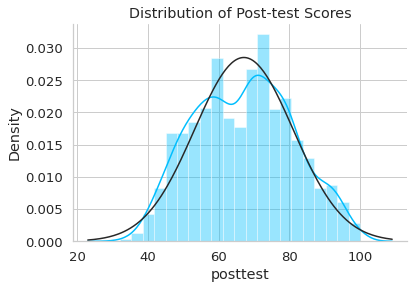

In [12]:
# Checking distribution of the target variable
sns.distplot(df['posttest'], fit=norm)
plt.title("Distribution of Post-test Scores")
sns.despine()

Distribution of target variable looks nearly normal. To view that statistically:

In [13]:
print(f"Skewness is {df['posttest'].skew()}")
print(f"Kurtosis is {df['posttest'].kurt()}")

Skewness is 0.07309634150773381
Kurtosis is -0.7196424790910436


Let's look at the relationships between independent and dependent variables

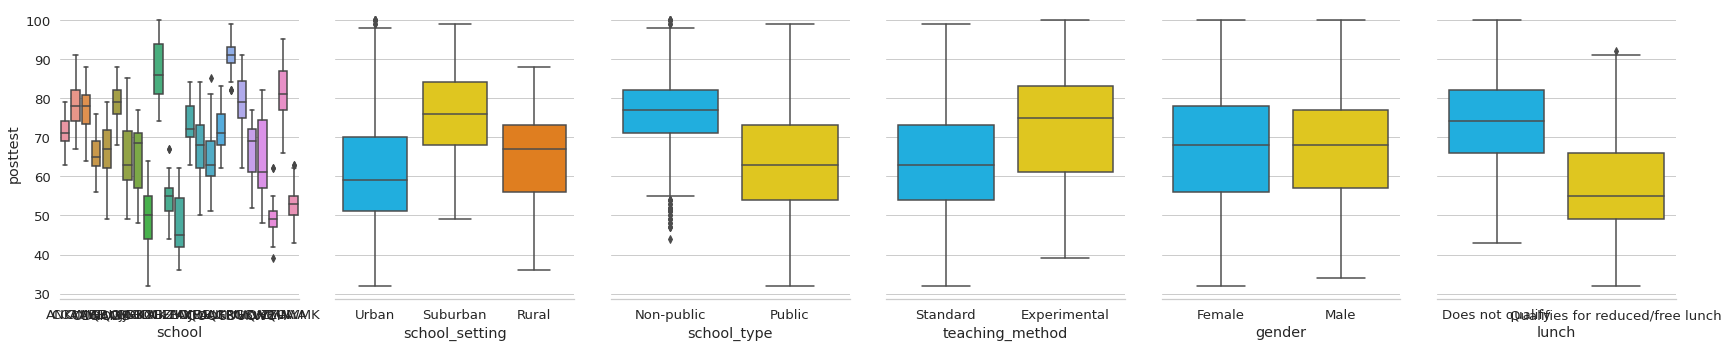

In [14]:
# Set up a grid to plot post-test score against the categorical variables
cat_vars = df.select_dtypes(exclude=['int64','float64']).columns.values
g = sns.PairGrid(df, y_vars="posttest",
                 x_vars=cat_vars,
                 height=5, aspect=0.8)

# Draw a seaborn pointplot onto each Axes
g.map(sns.boxplot)
sns.despine(fig=g.fig, left=True)

Few points we can understand from the above:  
- There are 23 different schools in the dataset and scores vary significantly by school. The visualization is not very helpful.
- Suburban schools have higher scores followed by Rural and Urban schools.
- Public schools have lower scores than the Non-public schools.
- Experimental teaching methods have higher test scores than standard ones.
- There is no significant difference (visually) between male and female scores.
- Students who qualify for reduced/free lunch have lower scores than those who do not qualify. This might be linked to students being from public and non-public schools.

In line with the last bullet points, there might be correlation between the predictor variables like `school_setting`, `school_type`, `teaching_method`, and `lunch`. We will explore that as well later in the notebook.  
Before moving forward, let's draw a cleaner version of the above chart.

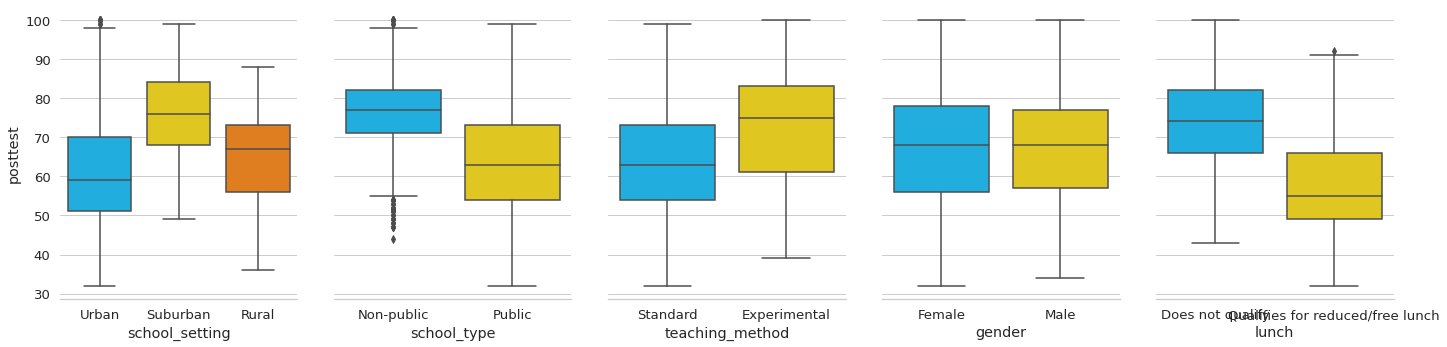

In [15]:
# Removing the school from categorical variables
cat_vars_new = np.delete(cat_vars,0)
g = sns.PairGrid(df, y_vars="posttest",
                 x_vars=cat_vars_new,
                 height=5, aspect=0.8)

# Draw a seaborn pointplot onto each Axes
g.map(sns.boxplot)
sns.despine(fig=g.fig, left=True)

Much better. Let's also look at the relationship of target variable with numeric predictor variables.

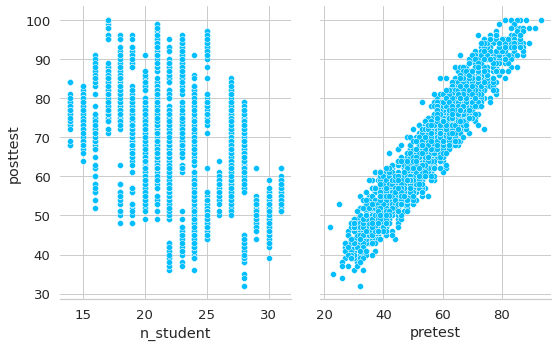

In [16]:
num_vars = df.select_dtypes(include=['int64','float64']).columns.values

# Remove the post-test variable itself
num_vars = np.delete(num_vars,-1)

g = sns.PairGrid(df, y_vars="posttest",
    x_vars=num_vars,
    height=5, aspect=0.8)

# Draw a seaborn pointplot onto each Axes
g.map(sns.scatterplot)
sns.despine(fig=g.fig, left=True)

What we can understand from the above:  
- There is a slight negative correlation between the number of students and post-test scores. Which makes sense as larger student batches might make it difficult to focus on individual student growth.
- There is a very strong correlation between pre-test scores and post-test scores. This also makes sense as pre-test performance is a good estimator of post-test performance.

Let's look at the share of different levels in categorical variables before converting them to dummy variables for running the model.

No data for index 5


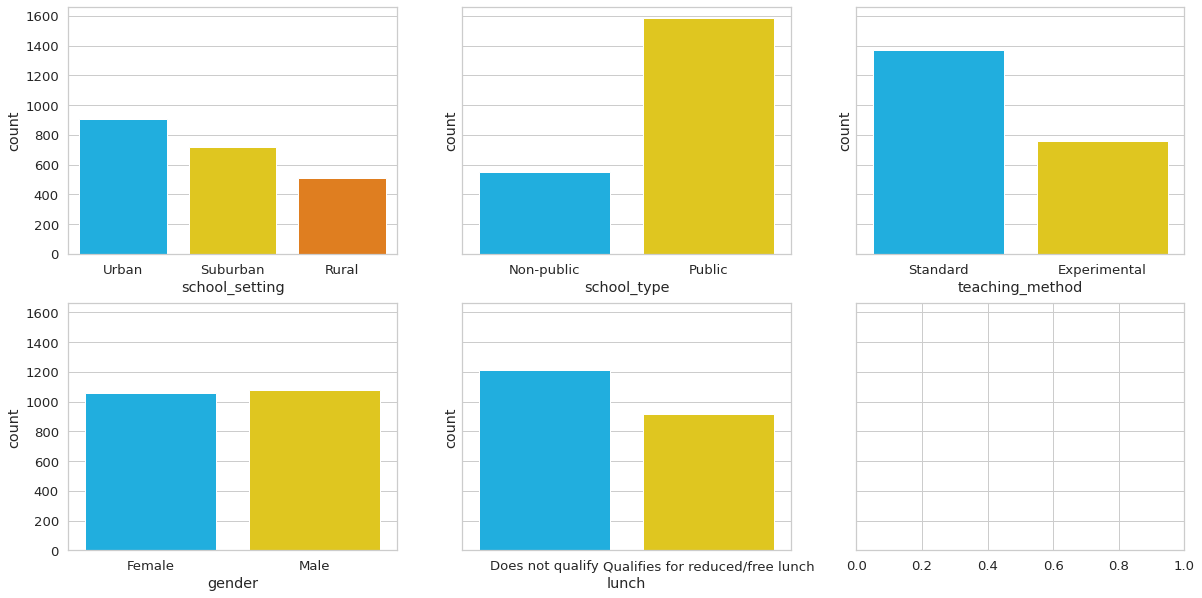

In [17]:
fig, axes = plt.subplots(2, 3, figsize = (20, 10), sharey=True)

for i, ax in enumerate(axes.flatten()):
  try:
    sns.countplot(df[cat_vars_new[i]], ax= ax)
  except IndexError:
    print(f"No data for index {i}")

Distribution of levels looks fine. There are no levels with very few samples. Let's also look at the distribution of levels for the `school` feature, which has high cardinality. 

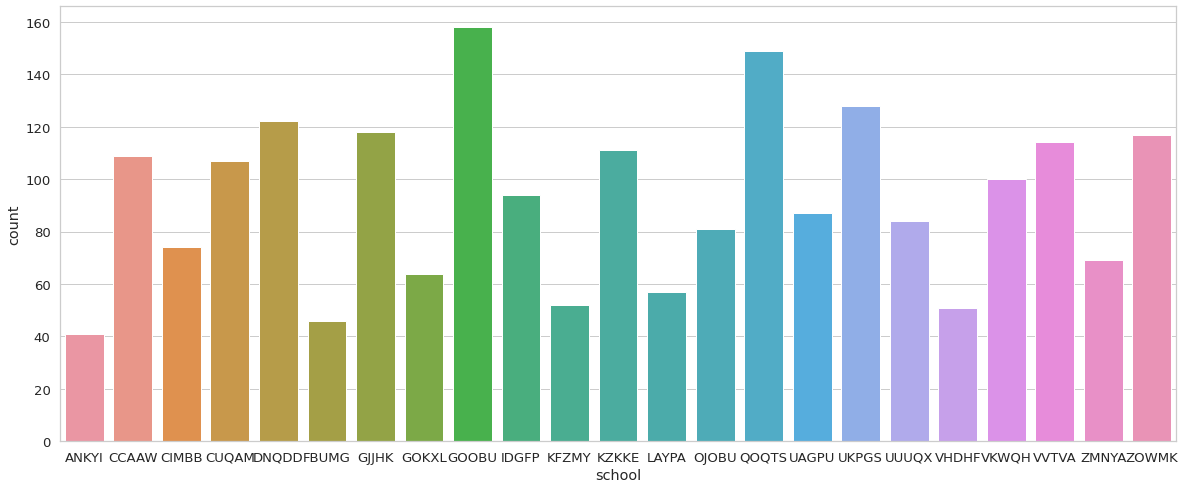

In [18]:
fig = plt.figure(figsize=(20,8))
sns.countplot(df.school)

From the above, we can see that we have at least 40 samples for each school which would be enough data even if we one-hot encode the column.

Let's create a one-hot encoded dataframe separately for visualization. We will keep the `df` intact as PyCaret will take care of encoding categorical variables in its experiment setup.

In [19]:
df_vis = pd.get_dummies(data=df,prefix=cat_vars,drop_first=True)

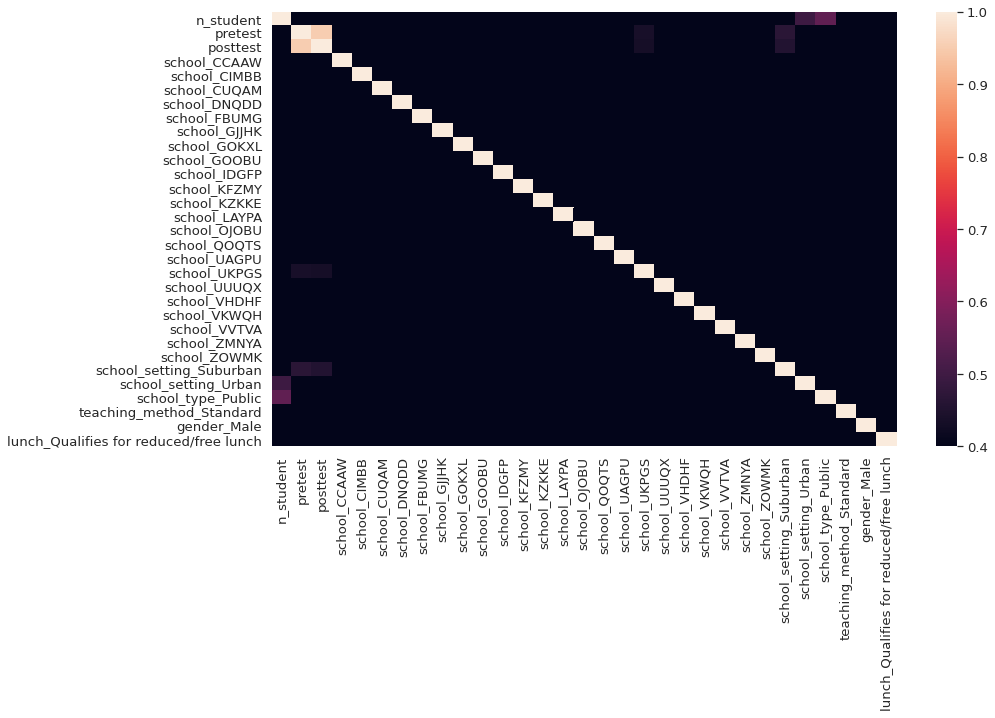

In [20]:
corr = df_vis.corr()

plt.figure(figsize=(14,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin=0.4)
plt.show()

While the figure above is a bit crowded, it is evident that there is no significant correlation apart from the one between `pretest` and `posttest`.  
Now that we have looked at the relationships, let's move onto building and finding the best models to predict our post-test scores.

## Step 4: Environment Setup in PyCaret

Keeping 10% of the data away as unseen samples. Will use that as test set later

In [21]:
data = df.sample(frac=0.9, random_state=42)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (1920, 9)
Unseen Data For Predictions (213, 9)


In [22]:
data.columns

Index(['school', 'school_setting', 'school_type', 'teaching_method',
       'n_student', 'gender', 'lunch', 'pretest', 'posttest'],
      dtype='object')

### Setting up the PyCaret experiment
Things considered and experimented with:

* Keeping 80% of the data for training and 20% for cross-validation
* Normalizing and transforming the numeric variables to scale and make them more gaussian like.
* Transforming the target variable as well. Using `box-cox` technique as target value has non-zero values.
<!-- * Using feature selection to reduce feature space. Removing low variance categorical features. -->
* Combining any rare levels in categorical features (Representing less than 5%)
* Removing any columns having >90% correlation
<!-- * Removing 2% of the extreme data as outliers -->

In [23]:
exp_score_pred = setup(data = data, target = 'posttest', session_id=101, train_size = 0.8,
                    normalize = True, transformation = True, transform_target = True, transform_target_method = 'box-cox',
                    categorical_features = ['school', 'school_setting', 'school_type', 'teaching_method', 'gender', 'lunch'],
                    numeric_features = ['n_student','pretest'],
                    high_cardinality_features = ['school'],
                    feature_selection = True, feature_selection_threshold = 0.9, ignore_low_variance = True,
                    remove_multicollinearity = True, multicollinearity_threshold = 0.9,
                    log_experiment = True, experiment_name = 'score_pred_1')

Description           Value
0                               session_id             101
1                                   Target        posttest
2                            Original Data       (1920, 9)
3                           Missing Values           False
4                         Numeric Features               2
5                     Categorical Features               6
6                         Ordinal Features           False
7                High Cardinality Features            True
8                  High Cardinality Method       frequency
9                    Transformed Train Set      (1536, 10)
10                    Transformed Test Set       (384, 10)
11                      Shuffle Train-Test            True
12                     Stratify Train-Test           False
13                          Fold Generator           KFold
14                             Fold Number              10
15                                CPU Jobs              -1
16                                 Use GPU           False
17                          Log Experiment            True
18                         Experiment Name    score_pred_1
19                                     USI            e466
20                         Imputation Type          simple
21          Iterative Imputation Iteration            None
22                         Numeric Imputer            mean
23      Iterative Imputation Numeric Model            None
24                     Categorical Imputer        constant
25  Iterative Imputation Categorical Model            None
26           Unknown Categoricals Handling  least_frequent
27                               Normalize            True
28                        Normalize Method          zscore
29                          Transformation            True
30                   Transformation Method     yeo-johnson
31                                     PCA           False
32                              PCA Method            None
33                          PCA Components            None
34                     Ignore Low Variance            True
35                     Combine Rare Levels           False
36                    Rare Level Threshold            None
37                         Numeric Binning           False
38                         Remove Outliers           False
39                      Outliers Threshold            None
40                Remove Multicollinearity            True
41             Multicollinearity Threshold             0.9
42             Remove Perfect Collinearity            True
43                              Clustering           False
44                    Clustering Iteration            None
45                     Polynomial Features           False
46                       Polynomial Degree            None
47                    Trignometry Features           False
48                    Polynomial Threshold            None
49                          Group Features           False
50                       Feature Selection            True
51                Feature Selection Method         classic
52            Features Selection Threshold             0.9
53                     Feature Interaction           False
54                           Feature Ratio           False
55                   Interaction Threshold            None
56                        Transform Target            True
57                 Transform Target Method         box-cox

In [24]:
models()

Name  ...  Turbo
ID                                           ...       
lr                        Linear Regression  ...   True
lasso                      Lasso Regression  ...   True
ridge                      Ridge Regression  ...   True
en                              Elastic Net  ...   True
lar                  Least Angle Regression  ...   True
llar           Lasso Least Angle Regression  ...   True
omp             Orthogonal Matching Pursuit  ...   True
br                           Bayesian Ridge  ...   True
ard       Automatic Relevance Determination  ...  False
par            Passive Aggressive Regressor  ...   True
ransac              Random Sample Consensus  ...  False
tr                       TheilSen Regressor  ...  False
huber                       Huber Regressor  ...   True
kr                             Kernel Ridge  ...  False
svm               Support Vector Regression  ...  False
knn                   K Neighbors Regressor  ...   True
dt                  Decision Tree Regressor  ...   True
rf                  Random Forest Regressor  ...   True
et                    Extra Trees Regressor  ...   True
ada                      AdaBoost Regressor  ...   True
gbr             Gradient Boosting Regressor  ...   True
mlp                           MLP Regressor  ...  False
xgboost           Extreme Gradient Boosting  ...   True
lightgbm    Light Gradient Boosting Machine  ...   True
catboost                 CatBoost Regressor  ...   True

[25 rows x 3 columns]

Testing several commonly used models

In [25]:
top3 = compare_models(fold = 5,
                      include = ['lr','lasso','ridge','en','huber','svm','dt','rf','et','mlp','xgboost','lightgbm','catboost'],
                      budget_time = 3,
                      n_select = 3)

Model      MAE       MSE     RMSE      R2  \
svm             Support Vector Regression   2.5027   10.0231   3.1635  0.9481   
catboost               CatBoost Regressor   2.5273   10.2212   3.1952  0.9471   
mlp                         MLP Regressor   2.5354   10.3479   3.2155  0.9464   
lr                      Linear Regression   2.5665   10.5421   3.2465  0.9454   
ridge                    Ridge Regression   2.5659   10.5412   3.2464  0.9454   
huber                     Huber Regressor   2.5682   10.5399   3.2462  0.9454   
lightgbm  Light Gradient Boosting Machine   2.5716   10.6548   3.2628  0.9448   
rf                Random Forest Regressor   2.6462   11.2507   3.3538  0.9417   
xgboost         Extreme Gradient Boosting   2.7391   12.0695   3.4729  0.9374   
et                  Extra Trees Regressor   2.8285   12.7580   3.5714  0.9339   
dt                Decision Tree Regressor   3.1863   16.2831   4.0342  0.9153   
en                            Elastic Net   8.3291  100.0394   9.9976  0.4827   
lasso                    Lasso Regression  11.6141  193.5401  13.9071 -0.0012   

           RMSLE    MAPE  TT (Sec)  
svm       0.0495  0.0389     0.118  
catboost  0.0500  0.0393     0.850  
mlp       0.0501  0.0392     0.300  
lr        0.0502  0.0397     0.658  
ridge     0.0503  0.0397     0.022  
huber     0.0502  0.0397     0.030  
lightgbm  0.0509  0.0399     0.154  
rf        0.0523  0.0411     0.504  
xgboost   0.0544  0.0426     1.658  
et        0.0561  0.0440     0.464  
dt        0.0631  0.0495     0.030  
en        0.1540  0.1324     0.024  
lasso     0.2112  0.1851     0.026

Okay, so we are getting the best performance both in terms of R<sup>2</sup> and MAE from the SVR model followede by CatBoost and Neural Network models.

Its already performing well. Let's see if we can improve further by tuning & ensembling.

In [26]:
# Take the top 3 models and blend them into an ensemble
blender_model = blend_models(top3, fold = 5)

MAE      MSE    RMSE      R2   RMSLE    MAPE
0     2.4241   9.6086  3.0998  0.9528  0.0490  0.0382
1     2.5253  10.3975  3.2245  0.9491  0.0522  0.0398
2     2.3264   8.8570  2.9761  0.9501  0.0459  0.0358
3     2.4390   9.2232  3.0370  0.9525  0.0466  0.0376
4     2.5821  10.6632  3.2655  0.9430  0.0501  0.0398
Mean  2.4594   9.7499  3.1206  0.9495  0.0487  0.0382
SD    0.0881   0.6853  0.1096  0.0035  0.0023  0.0015

In [27]:
# Tune the model hyperparams
tuned_blend_model = tune_model(blender_model)

MAE      MSE    RMSE      R2   RMSLE    MAPE
0     2.3295   8.8113  2.9684  0.9561  0.0460  0.0359
1     2.5203  10.4199  3.2280  0.9494  0.0520  0.0405
2     2.5547  10.7910  3.2850  0.9426  0.0502  0.0392
3     2.4515   9.4883  3.0803  0.9568  0.0520  0.0394
4     2.3223   8.4828  2.9125  0.9537  0.0456  0.0361
5     2.2978   8.7933  2.9654  0.9493  0.0454  0.0351
6     2.6661  10.2568  3.2026  0.9512  0.0496  0.0415
7     2.1610   7.7502  2.7839  0.9557  0.0416  0.0326
8     2.5162  10.1602  3.1875  0.9518  0.0496  0.0392
9     2.5345  10.1749  3.1898  0.9379  0.0488  0.0389
Mean  2.4354   9.5129  3.0803  0.9505  0.0481  0.0378
SD    0.1448   0.9511  0.1562  0.0058  0.0032  0.0026

We have achieved a finalR<sup>2</sup> score of **95.05%** and MAE score of **2.43**. These are great results and we can use this final model for plotting our results and finalize the model.

## Step 5: Plotting results & Finalizing Model
Let's check the model params and plot residuals, errors, and feature importances

In [28]:
plot_model(tuned_blend_model,plot = 'parameter')

Parameters
estimators                     [('svm', SVR(C=1.0, cache_size=200, coef0=0.0,...
n_jobs                                                                        -1
verbose                                                                    False
weights                                         [0.32, 0.8200000000000001, 0.46]
power_transformer_method                                                 box-cox
power_transformer_standardize                                               True
regressor                      VotingRegressor(estimators=[('svm',\n         ...

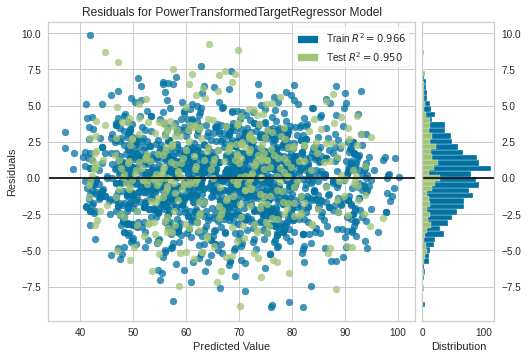

In [29]:
plot_model(tuned_blend_model)

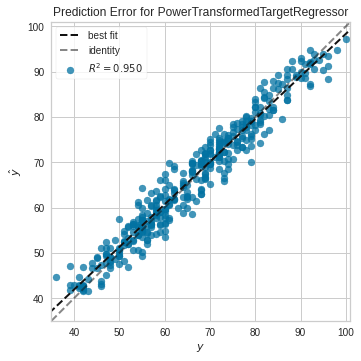

In [30]:
plot_model(tuned_blend_model, plot = 'error')

Checking performance on the CV set

In [32]:
predict_model(tuned_blend_model)

Model    MAE     MSE   RMSE      R2   RMSLE    MAPE
0  Voting Regressor  2.465  9.6971  3.114  0.9498  0.0495  0.0391

school  school_type_Non-public  ...  posttest      Label
0    1.798198                     0.0  ...      47.0  51.130289
1   -0.515637                     0.0  ...      79.0  70.151649
2   -1.599170                     1.0  ...      57.0  56.296093
3   -1.034851                     1.0  ...      77.0  75.243046
4   -1.034851                     1.0  ...      87.0  83.759251
..        ...                     ...  ...       ...        ...
379  0.711220                     1.0  ...      70.0  65.304720
380  0.535965                     0.0  ...      79.0  75.213955
381  0.535965                     0.0  ...      65.0  65.030742
382  0.593773                     0.0  ...      51.0  52.294506
383  0.256561                     0.0  ...      56.0  58.900042

[384 rows x 12 columns]

Finalize the model by using CV set for training as well

In [33]:
final_model = finalize_model(tuned_blend_model)

Checking performance for the finalized model

In [35]:
predict_model(final_model)

Model     MAE     MSE    RMSE     R2   RMSLE    MAPE
0  Voting Regressor  2.0919  7.1517  2.6743  0.963  0.0427  0.0332

school  school_type_Non-public  ...  posttest      Label
0    1.798198                     0.0  ...      47.0  50.152885
1   -0.515637                     0.0  ...      79.0  71.691866
2   -1.599170                     1.0  ...      57.0  55.814277
3   -1.034851                     1.0  ...      77.0  75.194340
4   -1.034851                     1.0  ...      87.0  84.398539
..        ...                     ...  ...       ...        ...
379  0.711220                     1.0  ...      70.0  66.782477
380  0.535965                     0.0  ...      79.0  75.578166
381  0.535965                     0.0  ...      65.0  64.723894
382  0.593773                     0.0  ...      51.0  51.655444
383  0.256561                     0.0  ...      56.0  58.142108

[384 rows x 12 columns]

## Step 6: Check accuracy on unseen data

In [36]:
unseen_pred = predict_model(final_model, data = data_unseen)

In [38]:
from pycaret.utils import check_metric
mae_test = check_metric(unseen_pred.posttest, unseen_pred.Label, 'MAE')
r2_test = check_metric(unseen_pred.posttest, unseen_pred.Label, 'R2')

print("The test set MAE is: {:.3f}, and R2 score is: {:.2f}".format(mae_test, r2_test))

The test set MAE is: 2.359, and R2 score is: 0.96


There is no significant drop in R<sup>2</sup> between dev and test sets with performance being even better on the test set, we can be sure that we have not overfit the data and our model generalizes well.

## Step 7: Saving the model

In [40]:
save_model(final_model,'drive/MyDrive/Colab Notebooks/Final Blend Model 20210802')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['school',
                                                             'school_setting',
                                                             'school_type',
                                                             'teaching_method',
                                                             'gender', 'lunch'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['n_student',
                                                           'pretest'],
                                       target='posttest', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical...
                                                                                                      lear

## Appendix: Next Steps / Ideas to Test

Few things that I could try to extend this analysis:
* Build data pipeline to make simplify re-training and predictions directly from the raw data
* Improve performance by tuning hyperparameters and trying oher setup configurations, such as experimenting with multicollinearity, binning, transformation, etc.
* Try other available models in `models()` to assess potential performance improvement